In [496]:
#import standard data analysis libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [497]:
df_pitching = pd.read_csv('pitcher_features.csv')

In [498]:
df_pitching.head()

,Unnamed: 0,total_bf,age,years_after_28,primary_position,throws,sp_pct_,total_bf_,sp_pct,whip_reg,...,fly_balls_ratio_pitcher_reg,ground_balls_ratio_pitcher_reg,line_drives_ratio_pitcher_reg,popups_ratio_pitcher_reg,hr_fb_pct_pitcher_reg,avg_bf_per_outing_reg,pitcher_avg_xwoba_reg,pitcher_avg_woba_reg,zone_chase_pct_reg,avg_fb_vel_reg
0,0,0.0,23.0,0.0,reliever,R,0.000000,56.250,2.883527,1.634001,...,1.194588,1.344661,1.177892,1.049938,0.207623,3.706988,0.390563,0.355679,0.616499,92.973393
1,1,218.0,29.0,1.0,reliever,L,0.000000,26.625,2.883527,1.148660,...,1.305724,1.667525,1.273387,0.254821,0.219309,2.875195,0.349642,0.292201,0.627072,93.001101
2,2,809.0,29.0,1.0,starter,L,100.000000,731.000,95.853353,1.254859,...,3.804790,20.124974,5.473928,1.082276,0.215285,13.940916,0.324974,0.289439,0.635585,87.752936
3,3,278.0,28.0,0.0,reliever,R,6.711409,241.750,2.883527,1.019444,...,1.048302,1.085554,1.044157,1.012396,0.095694,4.561512,0.345491,0.269180,0.630207,96.555288
4,4,282.0,28.0,0.0,reliever,R,0.000000,60.625,2.883527,2.342864,...,1.181615,1.321683,1.166032,1.046609,0.320766,4.755094,0.367187,0.408527,0.591293,95.522507


In [499]:
#drop columns not used in the model
df_pitching.drop(columns=['Unnamed: 0','primary_position','sp_pct','babip_pitcher_reg','years_after_28','pitcher_avg_exp_ba_reg','hr_fb_pct_pitcher_reg','throws'], inplace=True)

In [500]:
#!pip install lazypredict
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [501]:
X = df_pitching.drop(columns='total_bf')
y = df_pitching['total_bf']

In [502]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [503]:
# Scale features
numeric_cols = X_train.select_dtypes(include=np.number).columns

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [504]:
#convert categorical data
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

In [505]:
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import train_test_split

# Initialize the ElasticNetCV model (with 10-fold cross-validation)
elastic_net = ElasticNetCV(cv=10, random_state=42, alphas=np.logspace(-4, 4, 100), 
                           l1_ratio=0.5, max_iter=10000, tol=1e-4)

# Fit the ElasticNetCV model to the training data
elastic_net.fit(X_train, y_train)

# Get the best alpha and L1 ratio from cross-validation
best_alpha = elastic_net.alpha_
best_l1_ratio = elastic_net.l1_ratio_
print(f"Best alpha: {best_alpha}")
print(f"Best L1 ratio: {best_l1_ratio}")

# Predict the target on the test set
y_pred = elastic_net.predict(X_test)

# Ensure that the predicted values are non-negative (e.g., for a count variable like 'PA')
y_pred = np.maximum(y_pred, 0)

# Calculate the RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate the R² score (coefficient of determination)
r2 = r2_score(y_test, y_pred)


# Ensure that the predicted values are non-negative (e.g., for a count variable like 'PA')
y_pred = np.maximum(y_pred, 0)

# Calculate the RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate the R² score (coefficient of determination)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Best alpha: 0.14174741629268062
Best L1 ratio: 0.5
Root Mean Squared Error (RMSE): 148.6692
R² Score: 0.4719


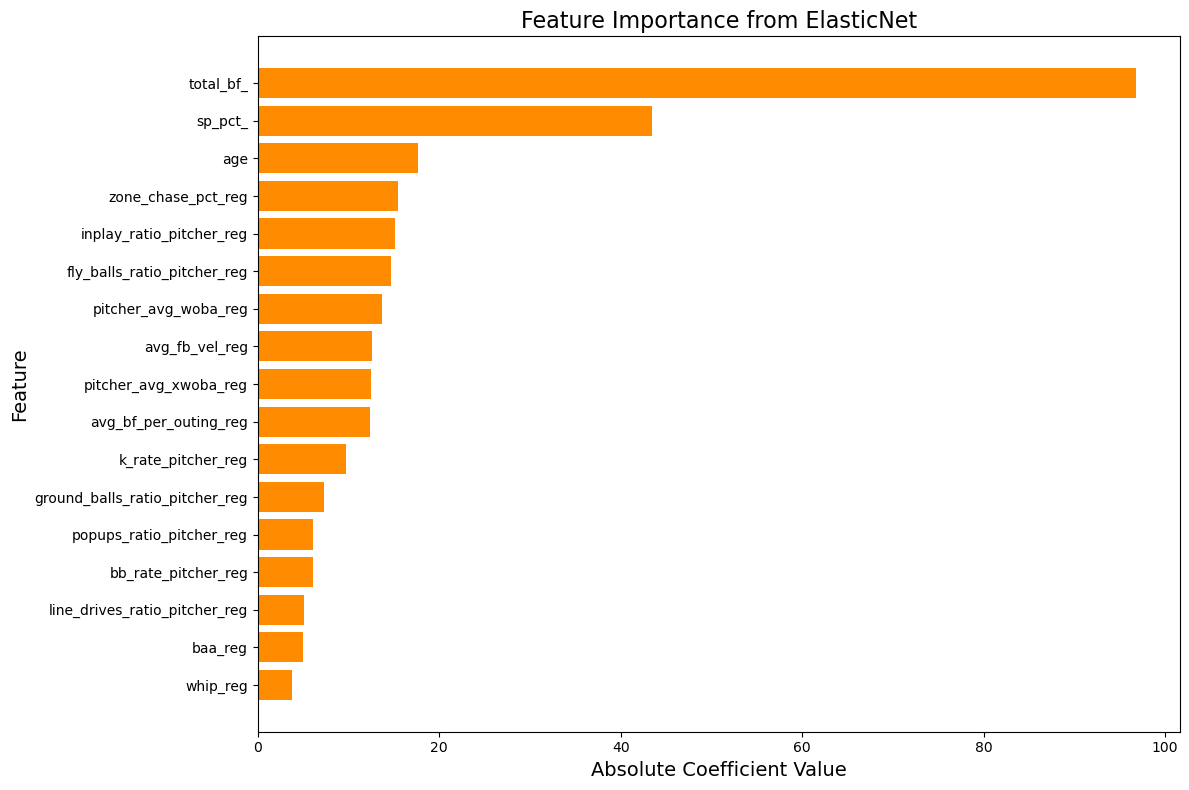

In [506]:
coefficients = elastic_net.coef_

# Create a DataFrame for the coefficients to associate with feature names
# After scaling, the feature names are lost, so we use the columns from X
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,  # Use the original feature names from X
    'Coefficient': coefficients
})

# Sort the features by the absolute value of the coefficients
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

# Set up the figure size
plt.figure(figsize=(12, 8))

# Create the bar plot
plt.barh(feature_importance['Feature'], feature_importance['Abs_Coefficient'], color='darkorange')

# Set labels and title
plt.xlabel('Absolute Coefficient Value', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importance from ElasticNet', fontsize=16)

# Invert y-axis to show most important features at the top
plt.gca().invert_yaxis()

# Adjust layout to prevent cutoff
plt.tight_layout()

# Save and show the plot
plt.savefig("pitching_feature_importance.jpg", bbox_inches='tight')
plt.show()


In [507]:
print("\nActual vs Predicted Values:")
print(pd.DataFrame({"Actual": y_test, "Predicted": y_pred}).head(20))  # Show first 20 rows


Actual vs Predicted Values:
     Actual   Predicted
711    23.0  150.788240
440   466.0  416.941162
525   160.0  109.124630
722    27.0   69.486812
39      0.0  140.590720
290   145.0  254.658787
300     0.0  140.336101
333   163.0    0.000000
208     0.0   37.831227
136    23.0   18.630057
137   116.0  514.449376
723     0.0    9.510446
486     0.0    0.000000
244   121.0  147.067945
344     0.0   43.187306
853    89.0  172.630181
572   273.0  178.744771
655   202.0  157.699844
891   258.0  227.073905
110     0.0   24.303479


In [508]:
df_pitching.loc[741]

total_bf                           0.000000
age                               27.000000
sp_pct_                            0.000000
total_bf_                         24.375000
whip_reg                           1.428132
baa_reg                            0.205876
k_rate_pitcher_reg                 0.168777
bb_rate_pitcher_reg                0.100286
inplay_ratio_pitcher_reg           0.170903
fly_balls_ratio_pitcher_reg        1.405737
ground_balls_ratio_pitcher_reg     1.718654
line_drives_ratio_pitcher_reg      1.370923
popups_ratio_pitcher_reg           1.104127
avg_bf_per_outing_reg              4.261380
pitcher_avg_xwoba_reg              0.375342
pitcher_avg_woba_reg               0.378625
zone_chase_pct_reg                 0.584252
avg_fb_vel_reg                    94.739117
Name: 741, dtype: float64

# Use model for predictions in 2024

In [510]:
df_pitching_final = pd.read_csv('pitcher_features_final_model.csv')

In [511]:
df_pitching_final.drop(columns=['Unnamed: 0','primary_position','sp_pct','total_bf','year','throws','babip_pitcher_reg','years_after_28','pitcher_avg_exp_ba_reg','hr_fb_pct_pitcher_reg'], inplace=True)
X_new = df_pitching_final.drop(columns='player_mlb_id')
player_ids = df_pitching_final['player_mlb_id']

In [512]:
#convert categorical data
X_new = pd.get_dummies(X_new, drop_first=True)

In [513]:
# Scale features
numeric_cols = X_new.select_dtypes(include=np.number).columns

scaler = StandardScaler()
X_new[numeric_cols] = scaler.fit_transform(X_new[numeric_cols])

In [514]:
# Assuming X_new is preprocessed and has the same features as X_train
y_new_pred = elastic_net.predict(X_new)

# Ensure non-negative predictions (if applicable)
y_new_pred = np.maximum(y_new_pred, 0)

In [515]:
df_pitcher_predictions = pd.DataFrame({
    'player_id': player_ids,  # Make sure player_ids matches the length of y_new_pred
    'predicted_value': y_new_pred
})

In [516]:
df_pitcher_predictions

,player_id,predicted_value
0,007d7209f1d3287648e11f52c5a5148732f7a791,89.546450
1,007dcc596b82af90fd37f3413e98812b87a6b305,140.498106
2,0110ddbbd4e67bbd0a355dd5561021b075920eb3,600.154126
3,01171c9c71028faf86b7447ec692000f50df9fac,272.244693
4,01b9d70c4ec72b8a0f733bdf6bc47df596617dfd,194.030606
...,...,...
1061,ff3b7d21e60c24b6e926e3ffc3fbeb78cc9e4057,260.035144
1062,ffa57541bf6d7030fdf7206f4aa0141a2c918647,413.518216
1063,ffbad18fedea89e09f42dac340e9ebb0bc18303d,44.504855
1064,ffc9b6a7a663bc322e74c70a5ed8756787a577d0,172.511501


Finalize prediction counts

In [518]:
submission = pd.read_csv('sample_submission.csv')
bat_pred = pd.read_csv('batting_predictions.csv')

In [519]:
predictions = bat_pred.merge(df_pitcher_predictions, on='player_id', how='outer').drop(columns='Unnamed: 0')

In [520]:
predictions = predictions.fillna(0)

In [521]:
predictions['PLAYING_TIME'] = predictions['predicted_value_x'] + predictions['predicted_value_y']

In [522]:
predictions

,player_id,predicted_value_x,predicted_value_y,PLAYING_TIME
0,0014c193005b425aaad55358686fb0dd1a4a0755,132.037951,0.000000,132.037951
1,003af1e4636109b822c9acfa703cb517c46d89fc,145.742600,0.000000,145.742600
2,0043ac96d4fde6fcfd5a841b8d902661e69a6009,253.488349,0.000000,253.488349
3,007d7209f1d3287648e11f52c5a5148732f7a791,0.000000,89.546450,89.546450
4,007dcc596b82af90fd37f3413e98812b87a6b305,0.000000,140.498106,140.498106
...,...,...,...,...
1914,ff6a1ab20dddd786a6d449658d8efdfe075cc3f2,82.721192,0.000000,82.721192
1915,ffa57541bf6d7030fdf7206f4aa0141a2c918647,0.000000,413.518216,413.518216
1916,ffbad18fedea89e09f42dac340e9ebb0bc18303d,0.000000,44.504855,44.504855
1917,ffc9b6a7a663bc322e74c70a5ed8756787a577d0,0.000000,172.511501,172.511501


In [523]:
submission = submission.merge(predictions, left_on='PLAYER_ID', right_on='player_id',how='left',suffixes=('_',''))

In [524]:
submission_csv = submission[['PLAYER_ID','PLAYING_TIME']]
submission_csv.to_csv('fordham_2024_predictions.csv')

<Axes: xlabel='PLAYING_TIME', ylabel='Count'>

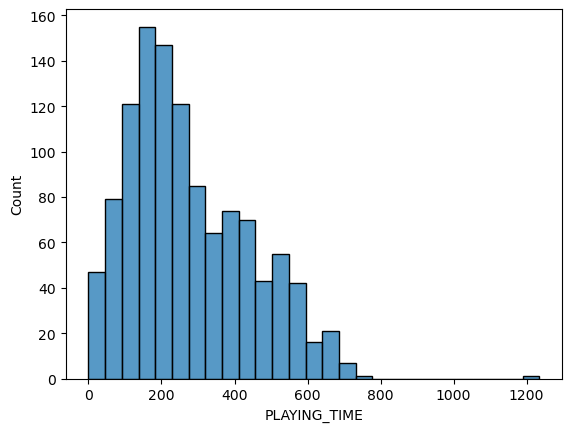

In [525]:
sns.histplot(submission_csv['PLAYING_TIME'])